# Assignment 1 (Analytics for Unstructured Data) - Team Members

### Pranav Garg
### Utkarsh Garg
### Ronak Goyal
### Akash Barathan
### Alex Imhoff
### John Izzo

In [3]:
import csv
import re
import string
from collections import defaultdict
from nltk.corpus import stopwords
import nltk
import io
import time
import pandas as pd
from itertools import combinations
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
from sklearn import manifold
from sklearn.cluster import DBSCAN
from matplotlib.patches import Ellipse
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pranvgarg/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## SCRAPPING PART

In [4]:
#Selenium is an open-source tool that automates web browsers.
!pip install selenium
!apt-get -q update   #Used to handle installation and removal of softwares and libraries
!apt install -yq chromium-chromedriver #ChromeDriver is a separate executable that Selenium WebDriver uses to control Chrome.
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

#Necessary libraries to be imported
import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
from selenium import webdriver
from selenium.webdriver.common.by import By

#WebDriver is a browser automation framework that works with open source APIs.
#The framework operates by accepting commands, sending those commands to a browser, and interacting with applications.
chrome_options = webdriver.ChromeOptions()

#Headless means running chrome with chrome.exe
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

zsh:1: command not found: apt-get
The operation couldn’t be completed. Unable to locate a Java Runtime.
Please visit http://www.java.com for information on installing Java.

cp: /usr/lib/chromium-browser/chromedriver: No such file or directory


In [5]:
wd = webdriver.Chrome(options=chrome_options)
wd.get("https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans")
# print(wd.page_source)

In [6]:
base_url = 'https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p'

all_messages = []
all_users = []
all_dates = []

for page_number in range(300,436):
  url = f'{base_url}{page_number}'
  wd.get(url)
  time.sleep(2)
  messages = wd.find_elements(By.XPATH, "//div[@class='Message userContent']")
  users = wd.find_elements(By.XPATH, "//span[@class='Author']")
  dates = wd.find_elements(By.XPATH, "//span[@class='MItem DateCreated']")
  for message in messages:
    all_messages.append(message.text.strip())
  for user in users:
    all_users.append(user.text.strip())
  for date in dates:
    all_dates.append(date.text.strip())

In [7]:
for m in all_messages[:5]:
  print(m)
  print('--------------------------------------------------')
print(len(all_users))

During my family visit in the Old Country this Xmas, I drove my dad's Audi A4 1.9TDI (2005, I think).

Would never switch my 328i for it (or previous WRX/STI, or any other good gasoline engine), not in milion years. The clacking sound is still something to get used to. I appreciate better fuel economy and torque, but everything else is better on a good gasoline engine: sound (as for pleasure of well-running engine), noise level, vibrations, weight. Yes, the torque is higher on diesel, but it lasts for 1000 rpm and then it's gone - and when it's gone and you forget to shift, you get run over. May not be such a problem for those new 7-, 8- speed automatic transmissions, but my dad's A4 had 6-speed manual. I love manual transmissions, but not on diesels, apparently - you end up shifting back and forth, always caught on wrong gear (car stops accelerating after the torque peak in merging/passing, or it starts vibrating when left on too high gear for current speed - often issue in city drivi

In [8]:
messages = [
    "This is a message from User1 in thread 'Introduction'.",
    "Another message from User2 in the same thread.",
    # Add more messages here
]

# Convert to DataFrame with a single column
df = pd.DataFrame({
    'User': all_users,
    'Date': all_dates,
    'Message': all_messages
})

# Export to CSV in Colab
csv_path = 'messages.csv'  # Define the file path
df.to_csv(csv_path, index=False, encoding='utf-8')

print("Messages have been exported to 'messages.csv' successfully!")

Messages have been exported to 'messages.csv' successfully!


In [9]:
df_loaded = pd.read_csv('messages.csv')

# Display the DataFrame
df_loaded

,User,Date,Message
0,dino001,January 2013,During my family visit in the Old Country this...
1,stever,January 2013,A reporter would like to speak to a woman who ...
2,m6user,January 2013,In 2001 I was in Italy a couple of weeks for b...
3,buya,January 2013,Thank you. That was a helpful review. I almost...
4,dino001,January 2013,"Perhaps you're right, but VAG's 1.9TDI (previo..."
...,...,...,...
6778,benjaminh,July 2020,There's speculation that the ILX name might be...
6779,stickguy,July 2020,"if they won't bring back Integra, the RSX is a..."
6780,benjaminh,July 2020,"Yes, I'd like to see Acura bring back a hatchb..."
6781,benjaminh,May 2021,@explorerx4 : How do you like your Lincoln MKZ...


## THESE ARE THE FUNCTIONS THAT WE MADE WHICH ARE BEING USED IN EACH TASK

In [82]:
# import Modules
import csv
import re
import string
from collections import defaultdict
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import io
import pandas as pd
from itertools import combinations
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
nltk.download('stopwords')
from sklearn import manifold
from sklearn.cluster import DBSCAN
from matplotlib.patches import Ellipse
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns

# creating the function it check if a row of csv file is header or not used in {remove_header}
def is_header(row):
    """
    Heuristically determine if the row is a header.
    Returns True if the row is likely a header, otherwise False.
    """
    # Check if all elements in the row are strings (this is a heuristic)
    return all(isinstance(item, str) for item in row)

# Step 1: Remove header from the input CSV and create a new file without it
def remove_header(input_file, output_file):
    """
    Reads the input CSV file, removes the header, and writes the remaining rows
    into a new output file.
    """
    with io.open(
    input_file, 'r', newline='', encoding = 'utf-8', errors='ignore') as infile, io.open(
        output_file, 'w', newline='', encoding = 'utf-8', errors='ignore'
        ) as outfile:
        inputs = csv.reader(infile)
        outputs = csv.writer(outfile)

        first_row = next(inputs)  # Read the first row
        
        # Check if the first row is a header
        if not is_header(first_row):
            # If it's not a header, write the first row as data
            outputs.writerow(first_row)

        # Skip the first row (header), then writes to the output file
        for index, row in enumerate(inputs):
            if index >= 0:  # This ensures we skip the header (index 0)
                outputs.writerow(row)
        
    print("Reading the file - ", {input_file})
    print("\nRemoving the header")
    print("\nWriting the file without header to - ", {output_file})
    return

# dependency for function {extract_sentences}
def clean_and_tokenize(sentence, remove_stopwords_flag=True, n_gram=False):
    """
    Cleans a given sentence by removing punctuation and stopwords, converting text to lowercase,
    and tokenizing the remaining words.
    
    If n_gram is specified (e.g., 2 for bigrams, 3 for trigrams), returns n-grams instead of individual words.
    """
    # Get the stopwords for the English language
    if remove_stopwords_flag:
        stop_words = set(stopwords.words('english'))
    else:
        stop_words = set([])

    # Remove punctuation and convert text to lowercase
    sentence = re.sub(f'[{re.escape(string.punctuation)}]', '', sentence.lower())
    
    # Tokenize the sentence
    words = [word for word in sentence.split() if word not in stop_words]
    sentence = ' '.join(words)
    words = word_tokenize(sentence)

    # print(words_vector)
    # Generate n-grams if specified
    if n_gram and n_gram > 1:
        result = [' '.join(words[i:i + n_gram]) for i in range(len(words) - n_gram + 1)]
    else:
        result = words

    return result

# Step 2: Extract and clean sentences from the text
def extract_sentences(file,sentence_column_index=2, remove_stopwords_flag = True, n_gram=False):
    """
    Extracts text data from the third column of the CSV file, splits it into sentences,
    and cleans each sentence by removing punctuation and stopwords.
    """
    sentences_clean=[]
    with io.open(file, 'r', newline='', encoding = 'utf-8', errors='ignore') as infile:
        inputs = csv.reader(infile)
        
        for index, row in enumerate(inputs):
            # Split the text into sentences based on punctuation (.?!)
            # Clean and tokenize each sentence
            comment = row[sentence_column_index]
            cleaned_tokens = clean_and_tokenize(comment, remove_stopwords_flag, n_gram)
            if cleaned_tokens:  # Avoid adding empty sentences
                    sentences_clean.append(cleaned_tokens)
            
    print("\nReading the file - ",{file})
    print("\nCleaning and tokenizing each sentence into given output list.")
    # print("sentences_clean_list count",len(sentences_clean))
    return sentences_clean

# Step 3: Calculate word frequencies -> helper function for {write_word_frequencies()}
def calculate_word_frequencies(comment_list, frequency_dict = {}, sentence_containing_word_flag = False):
    """
    Calculates the frequency of each word in the given list of cleaned sentences.
    """
    if sentence_containing_word_flag:
        unique_comment_list = list(set(comment_list))
        for token in unique_comment_list:
            try:
                frequency_dict[token] += 1
            except:
                frequency_dict[token] = 1
                
    else:
        for token in comment_list:
            try:
                frequency_dict[token] += 1
            except:
                frequency_dict[token] = 1

    return frequency_dict

# Step 4: Write word frequencies to CSV
def write_word_frequencies(clean_token_list, output_file, sentence_containing_word_flag = False):
    """
    Writes the word frequencies to the specified CSV file.
    """
    corpus_freq_dict = {}

    for sentence_token in clean_token_list:
        corpus_freq_dict = calculate_word_frequencies(sentence_token, corpus_freq_dict, sentence_containing_word_flag)
    
    print("\nCalculated corpus token frequncy for ", {len(corpus_freq_dict.keys())}, " tokens.")

    # Sort the dictionary by values in descending order
    corpus_freq_dict = dict(sorted(corpus_freq_dict.items(), key=lambda item: item[1], reverse=True))

    # writing final freq dictionary as a csv
    with open(output_file, 'w', newline='', encoding='utf-8', errors='ignore') as csvfile:
        writer = csv.writer(csvfile)
        
        # Write each key-value pair as a row in the CSV
        for key, value in corpus_freq_dict.items():
            writer.writerow([key, value])
    
    print(f"Word frequencies written to {output_file}")
    return

# Function to read the CSV file and test Zipf's Law excluding stopwords
def test_zipfs_law(file_path, top_num_words_to_print):
    # Step 1: Read the CSV file
    freq = pd.read_csv(file_path, header=None).iloc[:top_num_words_to_print, 1].to_list()
    word = pd.read_csv(file_path, header=None).iloc[:top_num_words_to_print, 0].to_list()
    
    ranks = np.arange(1, len(freq) + 1)
    frequencies = np.array(freq)

    # Step 6: Plot the rank vs. frequency to test Zipf's Law (with log scale)
    plt.figure(figsize=(6, 3))
    plt.plot(ranks, frequencies, marker='o', linestyle='-', color='b', label='Word Frequencies')

    # Add a diagonal dotted line (Zipf's Law theoretical line)
    min_rank = min(ranks)
    max_rank = max(ranks)
    min_freq = min(frequencies)
    max_freq = max(frequencies)
    
    # Plotting the diagonal line for Zipf's Law (log scale plot)
    plt.plot([min_rank, max_rank], [max_freq, min_freq], 'r--', label="Zipf's Law (Ideal)", linewidth=2)
    plt.xscale('log')
    plt.yscale('log')
    plt.title("Zipf's Law Test: Word Rank vs Frequency (Log Scale)")
    plt.xlabel('Rank (log scale)')
    plt.ylabel('Frequency (log scale)')
    plt.grid(True)
    plt.legend()
    plt.show()

    # Step 7: Plot the same graph without log scales
    plt.figure(figsize=(6, 3))
    plt.plot(ranks, frequencies, marker='o', linestyle='-', color='b', label='Word Frequencies')

    # Plotting the diagonal line for Zipf's Law (no log scale plot)
    plt.plot([min_rank, max_rank], [max_freq, min_freq], 'r--', label="Zipf's Law (Ideal)", linewidth=2)
    plt.title("Zipf's Law Test: Word Rank vs Frequency (No Log Scale)")
    plt.xlabel('Rank')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.legend()
    plt.show()

    # Step 8: Print the top words and their frequencies
    print(f"Top {top_num_words_to_print} Words by Frequency:")
    for w, f in zip(word, freq):
        print(f'{w}: {f}')
    
    # frequencies = data.iloc[:, 1].to_numpy()
    # ranks = np.arange(1, len(frequencies) + 1)

    # Step 2: Log-transform the ranks and frequencies
    log_ranks = np.log(ranks)
    log_frequencies = np.log(frequencies)

    # Step 3: Fit a linear regression model to the log-transformed data
    lin_reg = LinearRegression()
    lin_reg.fit(log_ranks.reshape(-1, 1), log_frequencies)

    # Obtain the slope and intercept
    slope = lin_reg.coef_[0]
    intercept = lin_reg.intercept_

    # Predicted values
    predicted_log_freqs = lin_reg.predict(log_ranks.reshape(-1, 1))

    # Step 4: Print the slope and intercept
    print(f"\n--Zipf's Law Slope Test--\n Slope: {slope}")
    print(f"Intercept: {intercept}")

    # Step 5: Perform t-test to test if the slope is -1
    slope_se = np.sqrt(np.sum((log_frequencies - predicted_log_freqs) ** 2) / ((len(log_ranks) - 2) * np.sum((log_ranks - np.mean(log_ranks)) ** 2)))
    t_statistic = (slope + 1) / slope_se
    p_value = 2 * (1 - stats.t.cdf(np.abs(t_statistic), df=len(log_ranks) - 2))

    print(f"T-statistic: {t_statistic}")
    print(f"P-value: {p_value}")

    # Conclusion based on p-value
    if p_value < 0.05:
        print("Reject the null hypothesis: The slope is significantly different from -1. Therefore following Zipf's Law.")
    else:
        print("Fail to reject the null hypothesis: The slope is not significantly different from -1. Therefore not following Zipf's Law.")

    return

# 
def load_replacements(replacement_file):
    """
    Load word replacements from a CSV file into a dictionary.
    The right column contains words to be replaced by the corresponding words in the left column.
    """
    replacements_dict = {}
    with open(replacement_file, 'r', encoding='utf-8') as csvfile:
        reader = csv.reader(csvfile, delimiter=',', quotechar='"')
        for row in reader:
            
            original, replacement = row[1].lower(), row[0].lower()  # Ensure lowercase comparison
            replacements_dict[original] = replacement
    replacements_dict_without_header = {}
    for non_header_key in list(replacements_dict.keys())[1:]:
        replacements_dict_without_header[non_header_key] = replacements_dict[non_header_key]
    return replacements_dict_without_header

# 
def replace_words_in_text(text, replacements_dict):
    """
    Replace words in the input text according to the replacements dictionary.
    """
    # processed_row_str = text.split()
    text = text.lower()
    for model, brand in replacements_dict.items():
        if model in text:
            # If model is found in the row, replace it with the brand
            text = text.replace(model, brand)
            
            # Also replace in the individual elements of processed_row
            # processed_row = [cell.replace(model, brand) for cell in list(text)]
    
    return text

# 
def process_file(input_file, output_file, replacements_dict, sentence_column_index=2):
    """
    Read the input file, perform word replacements, and write the modified content to the output file.
    """
    # Replace the original file with the modified file
    with io.open(
    input_file, 'r', newline='', encoding = 'utf-8', errors='ignore') as infile, io.open(
        output_file, 'w', newline='', encoding = 'utf-8', errors='ignore'
        ) as outfile:
        inputs = csv.reader(infile)
        outputs = csv.writer(outfile)

        for index, row in enumerate(inputs):
            comment = row[sentence_column_index]
            find_replace_comment = replace_words_in_text(comment,replacements_dict)
            
            outputs.writerow([find_replace_comment])

    return

# 
def print_and_write_top_freq_words(csv_file, replacement_dict, output_file):
    """
    Reads a CSV file, filters the rows based on the replacement_dict values,
    prints the top 10 frequent words, and writes the result to a text file.

    :param csv_file: Path to the CSV file with word frequencies.
    :param replacement_dict: Dictionary whose values are used to filter words.
    :param output_file: Path to the output text file.
    """
    # Step 1: Read the CSV file
    df_task_b = pd.read_csv(csv_file, header=None)

    # Step 2: Filter the DataFrame based on replacement_dict values
    df_task_b = df_task_b[df_task_b[0].isin(replacement_dict.values())]

    # Step 3: Print the top 10 words
    top_10_words = df_task_b.head(10)
    print(top_10_words)

    with open(output_file, 'w', newline='', encoding='utf-8', errors='ignore') as file:
    # Collect all words from the DataFrame
        words = [str(row[0]) for index, row in top_10_words.iterrows()]
        
        # Write the words, separated by commas
        file.write(', '.join(words))

    print(f"Top 10 frequent words have been written to {output_file}")


def filter_brand_tokens(brand_list,clean_token_list):
        """
        Takes and input of lists of nested list of tokenized sentences and
        a list of brand names > outputs a nested list with tokenized sentences of only brands
        """
        brand_token_list = []
        for sentence in clean_token_list:
            brand_token_sentence_list = []
            for token in sentence:
                if token in brand_list:
                    brand_token_sentence_list.append(token)
                
            if len(brand_token_sentence_list) > 0:
                brand_token_list.append(brand_token_sentence_list)

        return brand_token_list

def calculate_distance_btw_words(post, word1, word2):
    """
    Calculate the minimum distance between two words in a post.
    The distance is based on word positions.
    """
    word1_positions = [i for i, word in enumerate(post) if word == word1]
    word2_positions = [i for i, word in enumerate(post) if word == word2]

    if not word1_positions or not word2_positions:
        return float('inf')  # If either word is missing, return infinity

    # Calculate all distances and return the minimum
    return min(abs(pos1 - pos2) for pos1 in word1_positions for pos2 in word2_positions)


def co_occurance_freq(word1, word2, clean_token_list, distance):
    coorrence_count = 0
    for sentence_tokens in clean_token_list:
        if (word1 in sentence_tokens) & (word2 in sentence_tokens):
            min_dis_btw_word = calculate_distance_btw_words(sentence_tokens, word1, word2)
            if min_dis_btw_word <= distance:
                coorrence_count += 1

    return coorrence_count

def get_lift(top_10_brand_df, clean_token_list, dis, word_freq_output):

    word_pair_list= []
    word_pair_list.extend(list(combinations(top_10_brand_df, 2)))

    count_df = pd.read_csv(word_freq_output,header=None)

    # Create an empty matrix for all unique words
    lift_values = []
    lift_matrix = pd.DataFrame(index=top_10_brand_df, columns=top_10_brand_df, data=0.0)

    for w1, w2 in word_pair_list:
        w1_w2_count_co_occurance = co_occurance_freq(w1, w2, clean_token_list, dis)
        w1_count = int(count_df[count_df[0]==w1][1].iloc[0])
        w2_count = int(count_df[count_df[0]==w2][1].iloc[0])
        total_sentences = len(clean_token_list)
        lift_value = (total_sentences * w1_w2_count_co_occurance) / (w1_count * w2_count)
        lift_matrix.loc[w1,w2] = lift_value
        lift_values.append([w1,w2,lift_value])

        print(f"\n{'-' * 50}")
        print(f"LIFT CALCULATION FOR: {w1} and {w2}")
        print(f"Word Freq for {w1} : {w1_count}")
        print(f"Word Freq for {w2} : {w2_count}")
        print(f"Co-occurrence (word_pair_freq): {w1_w2_count_co_occurance}")
        print(f"Lift Value: {lift_value}")
        print(f"{'-' * 50}\n")

    return lift_matrix, lift_values

def get_lift(top_10_brand_df, clean_token_list, dis, word_freq_output):

    word_pair_list= []
    word_pair_list.extend(list(combinations(top_10_brand_df, 2)))

    count_df = pd.read_csv(word_freq_output,header=None)

    # Create an empty matrix for all unique words
    lift_values = []
    lift_matrix = pd.DataFrame(index=top_10_brand_df, columns=top_10_brand_df, data=0.0)

    for w1, w2 in word_pair_list:
        w1_w2_count_co_occurance = co_occurance_freq(w1, w2, clean_token_list, dis)
        w1_count = int(count_df[count_df[0]==w1][1].iloc[0])
        w2_count = int(count_df[count_df[0]==w2][1].iloc[0])
        total_sentences = len(clean_token_list)
        lift_value = (total_sentences * w1_w2_count_co_occurance) / (w1_count * w2_count)
        lift_matrix.loc[w1,w2] = lift_value
        lift_values.append([w1,w2,lift_value])

        print(f"\n{'-' * 50}")
        print(f"LIFT CALCULATION FOR: {w1} and {w2}")
        print(f"Word Freq for {w1} : {w1_count}")
        print(f"Word Freq for {w2} : {w2_count}")
        print(f"Co-occurrence (word_pair_freq): {w1_w2_count_co_occurance}")
        print(f"Lift Value: {lift_value}")
        print(f"{'-' * 50}\n")

    return lift_matrix, lift_values

def replace_zeros_with_diagonal(df):
    n_rows, n_cols = df.shape

    # Iterate over the DataFrame and find zeros
    for i in range(n_rows):
        for j in range(n_cols):
            if (df.iloc[i, j] == 0) & (i!=j):
                # Find the diagonally opposite element and replace zero
                # opposite_value = df.iloc[n_rows - 1 - i, n_cols - 1 - j]
                df.iloc[i, j] = df.iloc[j, i]


    return df

def heatmap(df):
    plt.figure(figsize=(8, 6))
    sns.heatmap(df, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title('Heatmap')
    plt.show()
    return


def get_lift_task_f(top_10_brand_list, top_attribute_list, clean_token_list, dis , word_freq_output):

    # word_pair_list= []
    # word_pair_list.extend(list(combinations(top_10_brand_list, 2)))

    count_df = pd.read_csv(word_freq_output,header=None)

    # Create an empty matrix for all unique words
    lift_values = []
    lift_matrix = pd.DataFrame(index=top_attribute_list, columns=top_10_brand_list, data=0.0)
    for w1 in top_10_brand_list:
        for w2 in top_attribute_list:
            w1_w2_count_co_occurance = co_occurance_freq(w1, w2, clean_token_list, dis)
            w1_w2_count_co_occurance = co_occurance_freq(w1, w2, clean_token_list, dis)
            w1_count = int(count_df[count_df[0]==w1][1].iloc[0])
            w2_count = int(count_df[count_df[0]==w2][1].iloc[0])
            total_sentences = len(clean_token_list)
            lift_value = (total_sentences * w1_w2_count_co_occurance) / (w1_count * w2_count)
            lift_matrix.loc[w2,w1] = lift_value
            lift_values.append([w1,w2,lift_value])

            print(f"\n{'-' * 50}")
            print(f"LIFT CALCULATION FOR: {w1} and {w2}")
            print(f"Word Freq for {w1} : {w1_count}")
            print(f"Word Freq for {w2} : {w2_count}")
            print(f"Co-occurrence (word_pair_freq): {w1_w2_count_co_occurance}")
            print(f"Lift Value: {lift_value}")
            print(f"{'-' * 50}\n")

    return lift_matrix, lift_values

# done with help of chatGPT task 
def plot_cov_ellipse(cov, pos, nstd=2, ax=None, **kwargs):
    """Create a plot of the covariance ellipse."""
    if ax is None:
        ax = plt.gca()
    
    # Eigenvalue decomposition of the covariance matrix to get the axes
    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]

    # Compute angle and width/height of the ellipse
    angle = np.degrees(np.arctan2(*eigvecs[:, 0][::-1]))
    width, height = 2 * nstd * np.sqrt(eigvals)

    # Create the ellipse patch
    ellipse = Ellipse(xy=pos, width=width, height=height, angle=angle, **kwargs)

    return ax.add_patch(ellipse)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pranvgarg/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## THESE ARE THE FUCTIONS THAT WE MADE FOR EACH TASK AND WILL BE CALLING IT BELOW

In [83]:
def task_a():
    # TASK A

    # call everythung here  
    input_filename = 'messages.csv'  # Input file
    without_header_file = 'task_a/without_header_file_task_a.csv'  # Intermediate file without the column header
    word_freq_output = 'task_a/word_freq_task_a.csv'  # Output file for word frequencies

    # removing the header from input file
    remove_header(input_filename, without_header_file)

    clean_token_list = extract_sentences(without_header_file, sentence_column_index=2, remove_stopwords_flag = False) 

    # calculationg word freq over corpus and writing to csv
    write_word_frequencies(clean_token_list,word_freq_output)

    # plotting  freqs , validationg zipf's law and printing top 100 frequent words
    test_zipfs_law(word_freq_output,100)

def task_b():
    input_filename = 'messages.csv'  # Input file
    without_header_file = 'task_b/without_header_file_task_b.csv'  # Intermediate file without the column header
    word_freq_output = 'task_b/word_freq_task_b.csv'  # Output file for word frequencies
    car_model_brand = 'car_models_and_brands.csv'
    find_replace_input_filename = 'task_b/find_replace_input_filename_task_b.csv'
    top_10_words_txt_output_filename = 'task_b/Top_10_words_task_b.txt'


    # removing the header from input file
    remove_header(input_filename, without_header_file)

    replacement_dict = load_replacements(car_model_brand)
    process_file(input_filename, find_replace_input_filename, replacement_dict, sentence_column_index=2)

    clean_token_list = extract_sentences(find_replace_input_filename, sentence_column_index=0, remove_stopwords_flag = True) 

    # calculationg word freq over corpus and writing to csv
    write_word_frequencies(clean_token_list,word_freq_output, sentence_containing_word_flag = True)

    # # printing top 10 freq words {and wrute it laster to a txt file}
    print_and_write_top_freq_words(word_freq_output, replacement_dict, top_10_words_txt_output_filename)

def task_c():
    # TASK c
    # call everythung here  
    input_filename = 'messages.csv'  # Input file
    without_header_file = 'task_c/without_header_file_task_c.csv'  # Intermediate file without the column header
    word_freq_output = 'task_c/word_freq_task_c.csv'  # Output file for word frequencies
    car_model_brand = 'car_models_and_brands.csv'
    distance_btw_words = 20
    lift_matrix_filename_output = "task_c/lift_matrix.csv"
    find_replace_input_filename = 'task_c/find_replace_input_filename_task_c.csv'

    # removing the header from input file
    remove_header(input_filename, without_header_file) # commenting now coz sample file does not have header

    brand_list = list(load_replacements(car_model_brand).values())

    replacement_dict = load_replacements(car_model_brand)
    process_file(input_filename, find_replace_input_filename, replacement_dict, sentence_column_index=2)

    clean_token_list = extract_sentences(find_replace_input_filename, sentence_column_index=0, remove_stopwords_flag = False)
    # print(brand_list)
    brand_token_list = filter_brand_tokens(brand_list,clean_token_list)
    # print(brand_token_list)
    # # calculationg word freq over corpus and writing to csv
    write_word_frequencies(brand_token_list,word_freq_output)

    # getting top 10 brands and frq in a df
    top_10_brand_df = list(pd.read_csv(word_freq_output,header=None).iloc[:10,0])
    print(top_10_brand_df)

    # rewritting the word freq file for lift calculation
    write_word_frequencies(clean_token_list, word_freq_output, sentence_containing_word_flag = True)
    
    # getting the lift matrix
    lift_matrix,lift_values = get_lift(top_10_brand_df, clean_token_list, distance_btw_words, word_freq_output)

    #writing the lift matrix to output files to csv 
    lift_matrix.to_csv(lift_matrix_filename_output, index=True)
    heatmap(lift_matrix)

def task_d():
## Step 1: Load and process the dissimilarity matrix
    lift_brands = pd.read_csv('task_c/lift_matrix.csv', index_col=0)
    lift_brands = replace_zeros_with_diagonal(lift_brands)

    dissimilarity_matrix = 1 / lift_brands

    # Fill diagonal values with 0
    np.fill_diagonal(dissimilarity_matrix.values, 0)

    # Check if any values are infinity and replace them with 0
    dissimilarity_matrix.replace([np.inf, -np.inf], 0, inplace=True)
    
    # Step 2: Apply MDS
    seed = np.random.RandomState(seed=3)
    mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, 
                       random_state=seed, dissimilarity="precomputed", n_jobs=1)
    results = mds.fit(dissimilarity_matrix)
    coords = results.embedding_

    # Step 3: Perform DBSCAN clustering
    dbscan = DBSCAN(eps=0.7, min_samples=3)  # Adjust eps based on cluster separation
    clusters = dbscan.fit_predict(coords)

    ## Step 4: Plot the original MDS points (single color for points)
    plt.figure(figsize=(10, 6))
    
    # Plot MDS points (all in black)
    plt.scatter(coords[:, 0], coords[:, 1], marker='o', color='black')
    
    # Plot ellipses for clusters (different colors for ellipses)
    unique_clusters = np.unique(clusters)
    colors = plt.cm.get_cmap('tab10', len(unique_clusters))

    for cluster in unique_clusters:
        if cluster == -1:
            # Ignore noise points
            continue

        cluster_points = coords[clusters == cluster]

        # Plot ellipses using the covariance matrix with different colors for ellipses
        if len(cluster_points) > 1:  # Covariance requires more than one point
            cov = np.cov(cluster_points.T)
            mean = np.mean(cluster_points, axis=0)
            plot_cov_ellipse(cov, mean, nstd=2, ax=plt.gca(), edgecolor=colors(cluster), facecolor='none', linewidth=2)

    # Annotate the points with labels
    for label, x, y in zip(lift_brands.index, coords[:, 0], coords[:, 1]):
        plt.annotate(
            label,
            xy=(x, y), xytext=(-20, 20),
            textcoords='offset points', ha='left', va='bottom',
            bbox=dict(boxstyle='round,pad=0.5', fc='orange', alpha=0.5),
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

    plt.title("MDS Plot")
    plt.show() 

def task_f():
    # TASK F
    # call everythung here  
    input_filename = 'messages.csv'  # Input file
    without_header_file = 'task_f/without_header_file_task_f.csv'  # Intermediate file without the column header
    word_freq_output = 'task_c/word_freq_task_c.csv'  # Output file for word frequencies
    distance_btw_words = 1000000000
    lift_matrix_filename_output = "task_f/lift_matrix_task_f.csv"
    lift_matrix_filename_output_temp = "task_f/lift_matrix_task_f_temp.csv"
    car_model_brand = 'car_models_and_brands.csv'
    find_replace_input_filename = 'task_f/find_replace_input_filename_task_f.csv'

    # removing the header from input file
    remove_header(input_filename, without_header_file)
    
    replacement_dict = load_replacements(car_model_brand)
    process_file(input_filename, find_replace_input_filename, replacement_dict, sentence_column_index=2)

    # brand_list = list(load_replacements(car_model_brand).values())
    clean_token_list = extract_sentences(find_replace_input_filename, sentence_column_index=0, remove_stopwords_flag = False) 

    # getting top 10 brands and frq in a df
    top_10_brand_list = ['bmw', 'audi', 'acura', 'infiniti', 'cadillac']
    top_attribute_list = [
    "price",
    "performance",
    "driving",
    "luxury",
    "engine",
    "tech"
    ]
    
    # getting the lift matrix
    lift_matrix,lift_values = get_lift_task_f(top_10_brand_list,top_attribute_list, clean_token_list, distance_btw_words, word_freq_output)

    #GEtting the lift mtx format for mds
    top_10_brand_list.extend(top_attribute_list)
    lift_matrix_temp,lift_values_temp = get_lift(top_10_brand_list, clean_token_list, distance_btw_words, word_freq_output)

    #writing the lift matrix to output files to csv 
    lift_matrix.to_csv(lift_matrix_filename_output, index=True)

    #writing the lift matrix to output files to csv 
    lift_matrix_temp.to_csv(lift_matrix_filename_output_temp, index=True)

    heatmap(lift_matrix)

def task_h():
    # TASK H
    # call everythung here  
    input_filename = 'messages.csv'  # Input file
    without_header_file = 'task_h/without_header_file_task_h.csv'  # Intermediate file without the column header
    word_freq_output = 'task_h/word_freq_task_h.csv'  # Output file for word frequencies
    car_model_brand = 'car_models_and_brands.csv'
    find_replace_input_filename = 'task_h/find_replace_input_filename_task_h.csv'
    distance_btw_words = 50
    lift_matrix_filename_output = "task_h/lift_matrix_task_h.csv"
    find_replace_input_filename2 = 'task_h/find_replace_input_filename2_task_h.csv' # definiing a new file for post bi gram replacement

    # removing the header from input file
    remove_header(input_filename, without_header_file)

    # getting top 10 brands and frq in a df
    top_10_brand_list = [
    "bmw",
    "audi",
    "acura",
    "infiniti",
    "honda"
    ]
    
    aspirational_bigrams = [
    'love to','looking forward','desire to','aspire to',
    'long to','hope to','i like','like to','aspiration','desire','desirable','fancy','eager','dream','cant wait to',
    'love to','wish to','want to','aspire to','thinking to buy','love to buy',
    'want to own','love to own','like to own','have to own','nice to own','nice to buy','have to buy',
    'would love to buy','wish to own','looking to buy','looking forward to buy','next car',
    'prefer', 'promising', 'dream to buy',
    'decided to', 'top car',
    'would like to buy','would love to buy','eager to buy',
    'love to have','desire of','dream of', 'dream to', 'love to','to own','own','favorite','always wanted'
    ]

    replacement_dict = load_replacements(car_model_brand)
    process_file(input_filename, find_replace_input_filename, replacement_dict, sentence_column_index=2)
    # print(replacement_dict)

    replacement_dict_grams = {}
    for grams in aspirational_bigrams:
        replacement_dict_grams[grams]= ' aspirations '
    # print(replacement_dict_grams)

    # replacing bi gram words with word - aspirations
    process_file(find_replace_input_filename, find_replace_input_filename2, replacement_dict_grams, sentence_column_index=0)    

    clean_token_list = extract_sentences(find_replace_input_filename2, sentence_column_index=0, remove_stopwords_flag = False) 

    # rewritting the word freq file for lift calculation
    write_word_frequencies(clean_token_list, word_freq_output, sentence_containing_word_flag = True)
    
    # # getting the lift matrix
    lift_matrix,lift_values = get_lift_task_f(top_10_brand_list,['aspirations'], clean_token_list, distance_btw_words, word_freq_output)
    heatmap(lift_matrix)

    return


# **TASK A**

Reading the file -  {'messages.csv'}

Removing the header

Writing the file without header to -  {'task_a/without_header_file_task_a.csv'}

Reading the file -  {'task_a/without_header_file_task_a.csv'}

Cleaning and tokenizing each sentence into given output list.

Calculated corpus token frequncy for  {25155}  tokens.
Word frequencies written to task_a/word_freq_task_a.csv


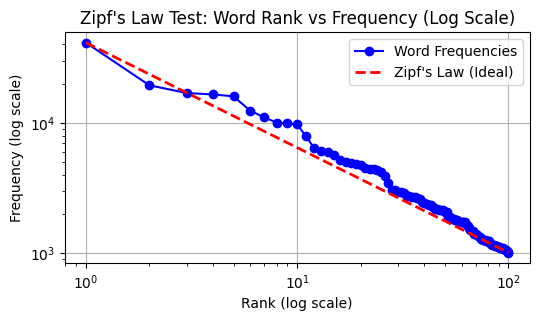

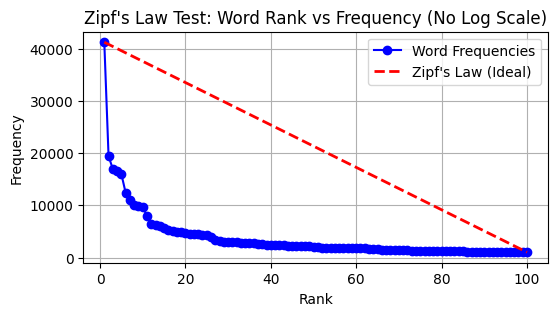

Top 100 Words by Frequency:
the: 41207
a: 19412
to: 16940
and: 16511
i: 15976
of: 12390
is: 11010
in: 10053
it: 9900
that: 9722
for: 7924
with: 6449
you: 6130
on: 6032
but: 5660
my: 5198
have: 5029
be: 4932
not: 4879
car: 4766
as: 4530
was: 4463
are: 4449
they: 4338
at: 4223
or: 3945
if: 3443
so: 3074
an: 3038
like: 2971
this: 2970
would: 2914
one: 2746
more: 2738
said: 2695
cars: 2690
its: 2679
just: 2594
has: 2460
bmw: 2424
all: 2373
will: 2360
about: 2355
new: 2256
than: 2207
can: 2190
get: 2157
what: 2150
me: 2137
from: 2083
had: 2072
no: 1897
up: 1886
out: 1851
think: 1846
there: 1802
some: 1794
we: 1764
when: 1750
even: 1747
audi: 1728
do: 1727
dont: 1690
their: 1621
im: 1558
good: 1518
your: 1480
much: 1475
now: 1416
well: 1410
time: 1384
really: 1350
which: 1337
them: 1300
by: 1295
only: 1274
too: 1262
better: 1255
were: 1252
drive: 1251
know: 1250
then: 1200
very: 1188
still: 1156
price: 1156
other: 1147
years: 1147
been: 1143
over: 1124
s4: 1113
same: 1100
how: 1099
also: 109

In [84]:
task_a()

So, as we can see that from plot and slope test that our slop is -0.85 and P-value is following Zipf's Law

# **TASK B**

In [85]:
task_b()

Reading the file -  {'messages.csv'}

Removing the header

Writing the file without header to -  {'task_b/without_header_file_task_b.csv'}

Reading the file -  {'task_b/find_replace_input_filename_task_b.csv'}

Cleaning and tokenizing each sentence into given output list.

Calculated corpus token frequncy for  {24824}  tokens.
Word frequencies written to task_b/word_freq_task_b.csv
              0     1
33          bmw  1788
60         audi  1212
94        acura   813
109       honda   674
213    infiniti   369
219  volkswagen   360
222      toyota   359
275    cadillac   292
289        ford   282
308     hyundai   270
Top 10 frequent words have been written to task_b/Top_10_words_task_b.txt


These are top 10 brands

# **TASK C**

Reading the file -  {'messages.csv'}

Removing the header

Writing the file without header to -  {'task_c/without_header_file_task_c.csv'}

Reading the file -  {'task_c/find_replace_input_filename_task_c.csv'}

Cleaning and tokenizing each sentence into given output list.

Calculated corpus token frequncy for  {25}  tokens.
Word frequencies written to task_c/word_freq_task_c.csv
['bmw', 'audi', 'acura', 'honda', 'volkswagen', 'infiniti', 'toyota', 'cadillac', 'hyundai', 'ford']

Calculated corpus token frequncy for  {24824}  tokens.
Word frequencies written to task_c/word_freq_task_c.csv

--------------------------------------------------
LIFT CALCULATION FOR: bmw and audi
Word Freq for bmw : 1788
Word Freq for audi : 1212
Co-occurrence (word_pair_freq): 401
Lift Value: 1.253855922505002
--------------------------------------------------


--------------------------------------------------
LIFT CALCULATION FOR: bmw and acura
Word Freq for bmw : 1788
Word Freq for acura : 813
Co-occurre

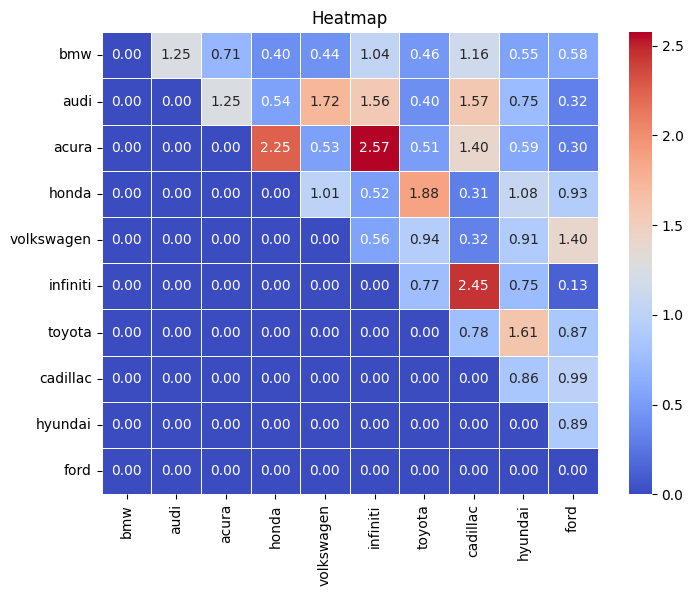

In [86]:
task_c()

# **TASK D**

/var/folders/kg/6zcpy_5d1cv8qp9ktgjrvmrw0000gn/T/ipykernel_16895/3051063477.py:115: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_clusters))


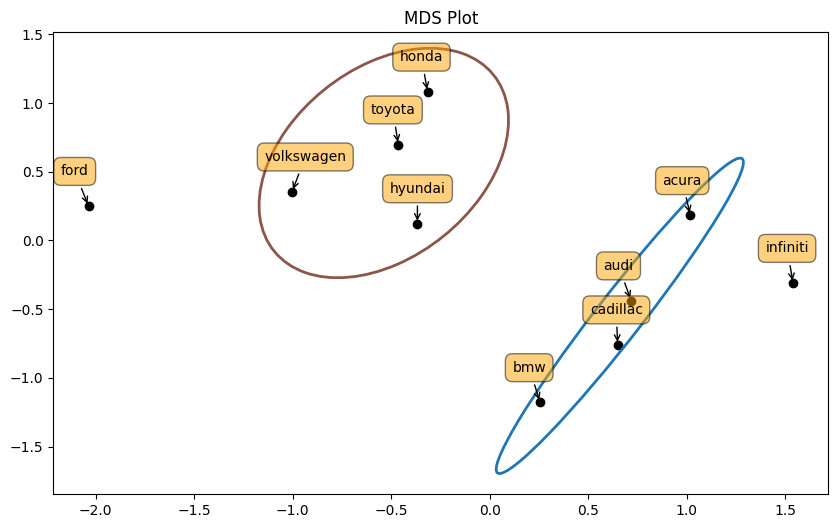

In [87]:
task_d()

### MDS Plot:
1. **Clusters**:
   - There’s a clear cluster formed by **Honda, Toyota, Volkswagen, and Hyundai** . These brands are positioned close together, suggesting that people tend to see them similarly, and there’s likely a higher chance of switching between them.
   - Another group clusters around the **luxury brands** like **Acura, Cadillac, BMW, Audi, and Infiniti** , indicating that customers of these premium brands are more likely to move between them.

2. **Brand Standouts**:
   - **Ford** and **Infiniti** are more isolated in the plot, suggesting that customers of these brands are less likely to switch to or from other brands. This could point to stronger loyalty or a more distinct brand image.

### Heatmap (Lift Values):
1. **High Switching Tendencies**:
   - **Acura and Infiniti (2.57)** & **Honda and Toyota (1.88)**, highlight strong switching or migration patterns. Essentially, customers are more likely to move between these brands.

2. **Low Switching Tendencies**:
   - Brands like **Ford** show low lift values with others, meaning that customers are less likely to switch in or out of Ford compared to other brands.

3. **Brand Migration Patterns**:
   - **Acura** shows particularly high lift values, hinting that Acura’s customers may frequently shift to other luxury brands, potentially due to similarities in brand image or positioning.

### Summary:  This is our WOWWW MOMENT!!!!!!!!!!!
- **Frequent Brand Switching**: Premium brands like Acura, Cadillac, and Infiniti exhibit high levels of customer switching.
- **Clustered Brands**: The MDS plot shows a strong connection between brands like Honda, Hyundai, Toyota, and Volkswagen, suggesting a shared low budgeted customer base.
- **Isolated Brands**: Ford stand apart, indicating that their customer bases might be more loyal or that these brands have a more distinct market perception.

# **TASK F**

Reading the file -  {'messages.csv'}

Removing the header

Writing the file without header to -  {'task_f/without_header_file_task_f.csv'}

Reading the file -  {'task_f/find_replace_input_filename_task_f.csv'}

Cleaning and tokenizing each sentence into given output list.

--------------------------------------------------
LIFT CALCULATION FOR: bmw and price
Word Freq for bmw : 1788
Word Freq for price : 811
Co-occurrence (word_pair_freq): 373
Lift Value: 1.7429858461810066
--------------------------------------------------


--------------------------------------------------
LIFT CALCULATION FOR: bmw and performance
Word Freq for bmw : 1788
Word Freq for performance : 478
Co-occurrence (word_pair_freq): 219
Lift Value: 1.7362893487967201
--------------------------------------------------


--------------------------------------------------
LIFT CALCULATION FOR: bmw and driving
Word Freq for bmw : 1788
Word Freq for driving : 595
Co-occurrence (word_pair_freq): 272
Lift Value: 1.732438

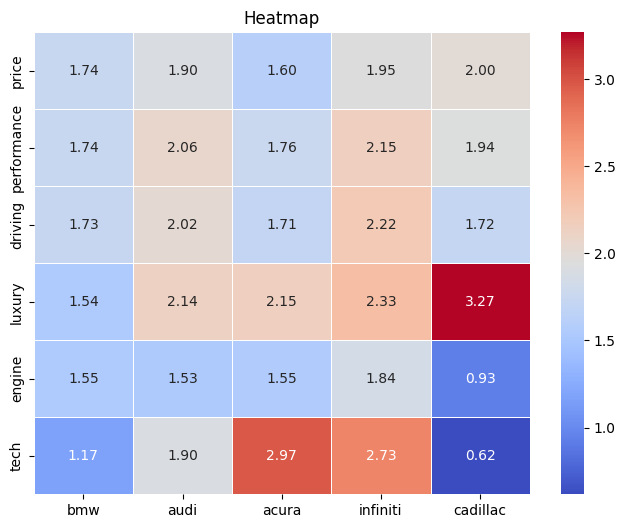

In [88]:
task_f()

Here is a concise interpretation of the **brand vs. attributes** lift heatmap:

### **Key Insights**:

1. **Luxury**:
   - **Cadillac** stands out with a very high lift value (3.27) for luxury, indicating that customers strongly associate Cadillac with luxury compared to other brands.
   - **Infiniti** also has a relatively high lift value (2.33), showing it has a strong luxury perception but less than Cadillac.

2. **Technology**:
   - **Acura** and **Infiniti** have notably high lift values (2.97 and 2.73, respectively) in the technology attribute, suggesting that these brands are perceived as technologically advanced by customers.
   - **BMW** and **Cadillac** score much lower (1.17 and 0.62), indicating that customers don’t strongly associate these brands with cutting-edge technology.

3. **Performance**:
   - **Audi** and **Infiniti** have relatively high lift values for driving performance (2.06 and 2.15), showing strong customer association with this attribute.
   - **Acura** has a slightly lower lift value (1.76), while **Cadillac** is somewhat neutral in this area (1.94).

4. **Price**:
   - The lift values for price are fairly consistent across all brands, with **Audi** (1.90) and **Infiniti** (1.95) being slightly higher, indicating a moderate association with pricing perceptions. **Acura** is the least associated with price (1.60) and **Cadillac** is the most associated with price (2.00)

5. **Engine**:
   - **Infiniti** (1.84) shows a slightly stronger association with engine attribute than others, while **Cadillac** is significantly low in this attribute (0.93), suggesting engine performance is not a strong point for Cadillac. We don't see much value associated with **BMW** eventhough it is an ulimate driving machine.

### **Summary**:
- **Cadillac** is strongly associated with luxury, but lacks in technology and engine performance.
- **Acura** and **Infiniti** are viewed as technology leaders, with **Infiniti** also being slightly strong in luxury and engine.
- **Audi** is well-balanced, especially in performance, while **BMW** shows a weaker association with tech and performance compared to its competitors.


# **TASK H**

Reading the file -  {'messages.csv'}

Removing the header

Writing the file without header to -  {'task_h/without_header_file_task_h.csv'}

Reading the file -  {'task_h/find_replace_input_filename2_task_h.csv'}

Cleaning and tokenizing each sentence into given output list.

Calculated corpus token frequncy for  {24742}  tokens.
Word frequencies written to task_h/word_freq_task_h.csv

--------------------------------------------------
LIFT CALCULATION FOR: bmw and aspirations
Word Freq for bmw : 1788
Word Freq for aspirations : 2272
Co-occurrence (word_pair_freq): 660
Lift Value: 1.1008838264486247
--------------------------------------------------


--------------------------------------------------
LIFT CALCULATION FOR: audi and aspirations
Word Freq for audi : 1212
Word Freq for aspirations : 2272
Co-occurrence (word_pair_freq): 447
Lift Value: 1.0999424766420305
--------------------------------------------------


--------------------------------------------------
LIFT CALCULATION F

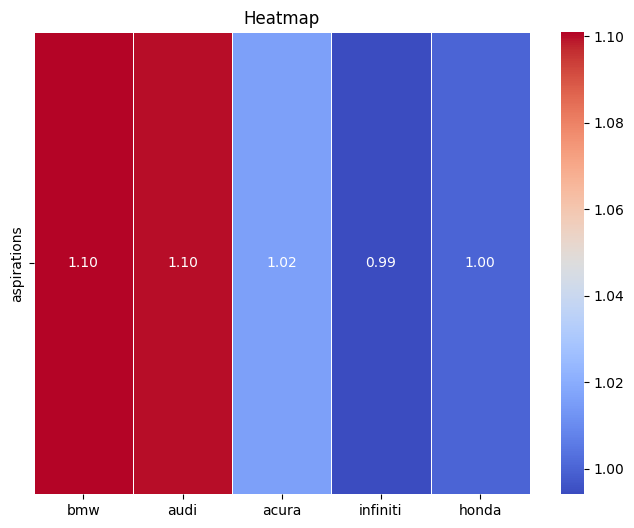

In [89]:
task_h()

### **Summary**:
- **BMW** and **Audi** are seen as aspirational, with customers viewing them as desirable, prestigious brands.
- **Acura** is moderately aspirational, but less so than BMW and Audi.
- **Honda** and **Infiniti** are less associated with aspiration, being seen as practical, reliable choices rather than status-driven purchases.

This shows how each brand is perceived in terms of customer aspiration, which can be useful for positioning and marketing strategies.

### AHA Moments!!!

- **BMW** promotes itself as the "Ultimate Driving Machine," but interestingly, the data reveals that BMW has the lowest lift values for attributes like performance, technology, and driving experience. This suggests a disconnect between the brand's image and how customers actually perceive it, indicating that BMW might want to rethink its tagline.
  
- However, when we explore the issue further, it becomes clear that despite this gap in perception, **BMW** still stands out as the most aspirational brand. This insight could guide the brand’s strategy moving forward, helping them better align their messaging with how customers view the brand while leveraging their aspirational appeal.
